In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from river.drift import DriftRetrainingClassifier
from river.linear_model import LogisticRegression
from river.metrics import Accuracy
from river.drift import ADWIN

In [2]:
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [3]:
X_df = df_cfpdss.drop(columns="class")
y_df = df_cfpdss[["class"]]
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
one_hot_encoded
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_encoded = y_encoder.fit_transform(y_df)
y_df_one_hot = pd.DataFrame(y_encoded, columns=y_encoder.get_feature_names_out())
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_df[[col for col in X_df.columns if col not in categorical_columns]],
    ],
    axis=1,
)
X_df_encoded.head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4
0,0,0,1,0,0,0.448573,1.212644,2.555515,0.242702,0.697604
1,0,0,0,1,1,1.902515,-0.467349,-0.744523,-0.017156,-0.380288
2,0,0,0,1,1,0.825045,1.002267,1.972207,-0.790095,0.233456
3,0,0,0,1,1,-0.124974,0.902601,1.696092,-0.320182,0.243261
4,1,0,0,1,0,-1.259765,0.793134,1.547527,-2.132172,-0.788367


In [4]:
X_df_encoded.dtypes

c5_b      int32
c6_b      int32
c7_b      int32
c8_b      int32
c9_b      int32
n0      float64
n1      float64
n2      float64
n3      float64
n4      float64
dtype: object

In [39]:
y_df_one_hot.head()
type(y_df_one_hot.iloc[0])
y_df_one_hot.iloc[0]

class_B    0
Name: 0, dtype: int32

In [6]:
X_df_encoded.isna().sum().sum()

0

In [11]:
from itertools import zip_longest


class StreamVisualization:

    def __init__(self, df: pd.DataFrame, y: pd.DataFrame):
        self.df = df
        self.y = y

    def plot(self, timepoint_start: int = 0, timepoint_end: int = 10):
        # Create main plot with subplots
        fig, axes = plt.subplots(
            nrows=len(self.df.columns), ncols=1, figsize=(8, 6), sharex=True
        )

        df = self.df.iloc[timepoint_start:timepoint_end]

        # Plot each feature against its index
        for i, col in enumerate(df.columns):
            axes[i].plot(df.index, df[col], marker="o", linestyle="-")
            axes[i].set_ylabel(col)
            axes[i].grid(True)

        # Set x-axis label for the last subplot
        axes[-1].set_xlabel("TimePoint")

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

    def detect_concept_drift(self):
        # Instantiate a logistic regression classifier

        if self.df.empty or self.y.empty:
            print("X_df_encoded or y_df_one_hot is empty")
            return
        if len(self.df) != len(self.y):
            print("X_df_encoded and y_df_one_hot have different lengths")
            return
        classifier = LogisticRegression()

        drift_detector = ADWIN()

        # Instantiate a drift retraining classifier with the logistic regression classifier and drift detector
        retraining_classifier = DriftRetrainingClassifier(
            model=classifier, drift_detector=drift_detector, train_in_background=False
        )

        # Create a data stream (replace with your own data stream)
        stream = zip_longest(self.df.iterrows(), self.y.iterrows())

        # Metrics for monitoring performance
        accuracy = Accuracy()
        #         print([i for i in stream])
        # Train and evaluate the drift retraining classifier on the data stream
        count = 0
        for (index, x), (_, y) in stream:
            # Predict the class label and update the model

            x_dict = x.to_dict()  # Assuming x contains a single row
            y_dict = y.to_dict()
            y_pred = retraining_classifier.predict_one(x_dict)
            #             print(y.item())
            retraining_classifier.learn_one(x_dict, y.item())

            # Update the drift detector and check for drift
            drift_detected = retraining_classifier.drift_detector.drift_detected

            # Update performance metrics
            accuracy.update(y.item(), y_pred)

            # If drift is detected, retrain the model
            count += 1
            if drift_detected:
                #                 retraining_classifier.reset()
                print(f"drif detected {count}")

            # Print performance metrics periodically (e.g., every 100 samples)
            if count % 100 == 0:
                print(f"Accuracy: {accuracy.get():.4f}")


stream_ = StreamVisualization(X_df_encoded, y_df_one_hot)
stream_.detect_concept_drift()

Accuracy: 0.6900
Accuracy: 0.7250
Accuracy: 0.7700
Accuracy: 0.7925
Accuracy: 0.7840
Accuracy: 0.7867
Accuracy: 0.7900
Accuracy: 0.7975
Accuracy: 0.8022
Accuracy: 0.8070
Accuracy: 0.8182
Accuracy: 0.8242
Accuracy: 0.8285
Accuracy: 0.8286
Accuracy: 0.8260
Accuracy: 0.8219
Accuracy: 0.8212
Accuracy: 0.8239
Accuracy: 0.8253
Accuracy: 0.8290
Accuracy: 0.8314
Accuracy: 0.8305
Accuracy: 0.8309
Accuracy: 0.8321
Accuracy: 0.8324
Accuracy: 0.8338
Accuracy: 0.8352
Accuracy: 0.8364
Accuracy: 0.8376
Accuracy: 0.8397
Accuracy: 0.8400
Accuracy: 0.8406
Accuracy: 0.8403
Accuracy: 0.8409
Accuracy: 0.8417
Accuracy: 0.8411
Accuracy: 0.8397
Accuracy: 0.8387
Accuracy: 0.8395
Accuracy: 0.8390
Accuracy: 0.8388
Accuracy: 0.8395
Accuracy: 0.8395
Accuracy: 0.8391
Accuracy: 0.8367
Accuracy: 0.8341
Accuracy: 0.8323
Accuracy: 0.8304
Accuracy: 0.8296
Accuracy: 0.8264
Accuracy: 0.8249
Accuracy: 0.8231
Accuracy: 0.8191
drif detected 5344
Accuracy: 0.8176
Accuracy: 0.8158
Accuracy: 0.8152
Accuracy: 0.8139
Accuracy: 0.

In [14]:
count = 0
for (_, x_row), (_, y_row) in zip(X_df_encoded.iterrows(), y_df_one_hot.iterrows()):
    # print(x_row, y_row)
    count += 1
    if count == 5:
        break

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [20]:
classifier = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(
    X_df_encoded.iloc[:50], y_df_one_hot.iloc[:50], test_size=0.2
)

# Train the classifier
classifier.fit(X_train, y_train)

# Evaluate initial performance
initial_accuracy = accuracy_score(y_test, classifier.predict(X_test))
initial_accuracy

0.8

In [ ]:
for (time_point, x_row), (_, y_row) in zip(
    X_df_encoded.iloc[50:].iterrows(), y_df_one_hot.iloc[50:].iterrows()
):
    # Retrain the classifier
    classifier.fit(x_row, y_row)

    # Evaluate current performance
    current_accuracy = accuracy_score(y_test, classifier.predict(X_test))

    # Detect concept drift
    if abs(current_accuracy - initial_accuracy) > threshold:
        print("Concept drift detected!")
        # Take appropriate actions
        # handle_concept_drift()

### Concept drift Idea Try from : [github repo](https://github.com/Western-OC2-Lab/PWPAE-Concept-Drift-Detection-and-Adaptation/blob/main/globecom2021_PWPAE_IoTID20.ipynb)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from river import metrics
from river import stream
from river import tree, neighbors, naive_bayes, ensemble, linear_model
from river.drift import ADWIN
from river.drift.binary import DDM

In [44]:
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
X_df = df_cfpdss.drop(columns="class")
y_df = df_cfpdss[["class"]]
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
one_hot_encoded
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_df[[col for col in X_df.columns if col not in categorical_columns]],
    ],
    axis=1,
)
type(y_encoded)

pandas.core.series.Series

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df_encoded,
    y_encoded,
    train_size=0.01,
    test_size=0.99,
    shuffle=False,
    random_state=0,
)
X_train.shape

(130, 10)

In [52]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy()  # Use accuracy as the metric
    i = 0  # count the number of evaluated data points
    t = []  # record the number of evaluated data points
    m = []  # record the real-time accuracy
    yt = []  # record all the true labels of the test set
    yp = []  # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1, yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred = model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi, yi)  # Learn the test sample
        metric.update(yi, y_pred)  # Update the real-time accuracy
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)
        i = i + 1
    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")
    return t, m

In [63]:
def acc_fig(t, m, name):
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t, m, "-b", label="Avg Accuracy: %.2f%%" % (m[-1]))

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Number of samples/Timepoint")
    plt.ylabel("Accuracy (%)")
    plt.axis([0, 13000, 82, 86])

    mplcursors.cursor(hover=True)

    plt.show()

Accuracy: 81.47999999999999%
Precision: 80.76%
Recall: 78.83%
F1-score: 79.78%


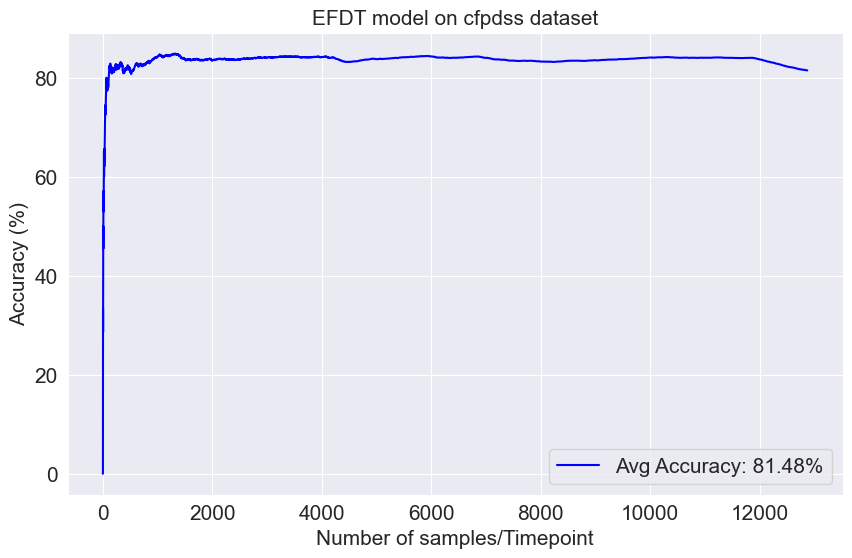

In [57]:
# Use the Extremely Fast Decision Tree (EFDT) model
name5 = "EFDT model"
model5 = tree.ExtremelyFastDecisionTreeClassifier()  # Define the model
t, m5 = adaptive_learning(
    model5, X_train, y_train, X_test, y_test
)  # Learn the model on the dataset
acc_fig(
    t, m5, name5
)  # Draw the figure of how the real-time accuracy changes with the number of samples

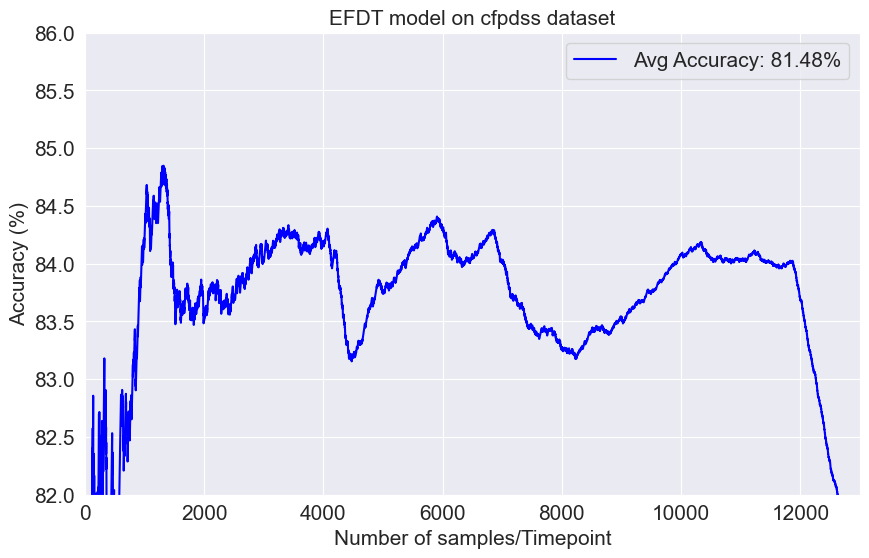

In [64]:
acc_fig(t, m5, name5)

Accuracy: 79.67%
Precision: 79.08%
Recall: 76.35%
F1-score: 77.69%


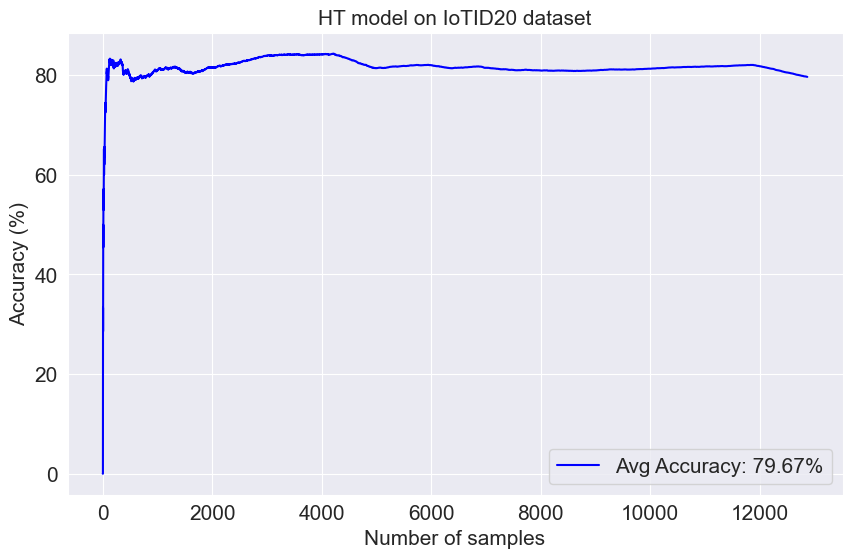

In [54]:
name6 = "HT model"
model6 = tree.HoeffdingTreeClassifier()  # Define the model
t, m6 = adaptive_learning(
    model6, X_train, y_train, X_test, y_test
)  # Learn the model on the dataset
acc_fig(
    t, m6, name6
)  # Draw the figure of how the real-time accuracy changes with the number of samples

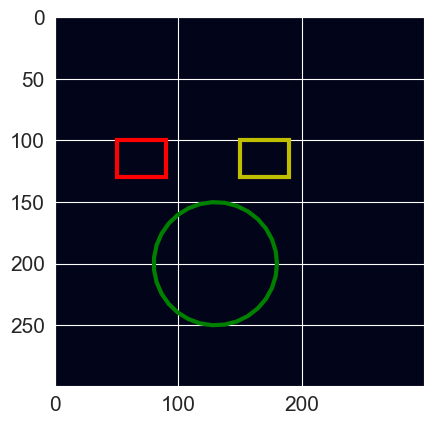

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
from matplotlib.patches import Rectangle, Polygon

fig, ax = plt.subplots(1, 1)
im = np.zeros((300, 300))
img = ax.imshow(im, interpolation="none")

ax.add_patch(
    Rectangle(
        (50, 100),
        40,
        30,
        linewidth=3,
        edgecolor="r",
        facecolor="none",
        label="first rectangle",
    )
)
ax.add_patch(
    Rectangle(
        (150, 100),
        40,
        30,
        linewidth=3,
        edgecolor="y",
        facecolor="none",
        label="second rectangle",
    )
)
th = np.linspace(0, 2 * np.pi, 32)
rad, cx, cy = 50, 130, 200
ax.add_patch(
    Polygon(
        rad * np.c_[np.cos(th), np.sin(th)] + np.array([cx, cy]),
        closed=True,
        linewidth=3,
        edgecolor="g",
        facecolor="none",
        label="a polygon\napproximating a circle",
    )
)

cursor = mplcursors.cursor(ax.patches, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set(text=sel.artist.get_label()))

plt.show()